Quantum chromodynamics (QCD) is the quantum field theory that describes the dynamics of particles called hadrons, which include the familiar protons and neutrons as well as particles which might be less familiar like pions and kaons. These hadrons are not fundamental particles, but rather are composed of quarks (which are massive fermions) and gluons (which are massless bosons). In analogy with electromagnetism, quarks can be thought of as charge carriers analogous to electrons and gluons are force carriers analogous to photons. In QCD, we call the charge carried by quarks "color", and QCD is unlike electromagnetism in that the gluons carry color as well.

This difference, the fact that gluons carry color charge, has dramatic effects: ultimately, it results in the phenomenon of color confinement, and this means that isolated quarks and gluons cannot be observed in nature. Rather, only color neutral combinations of quarks and gluons are observed, and the resulting composite particles are the hadrons described above.

Very high energy collisions between hadrons, like those occurring at the Large Hadron Collider, can be well-described as collisions between quark and/or gluon components of the colliding hadrons. These quarks and/or gluons are then, more or less, knocked out of their hadrons at relativistic speeds. Then, over extremely short timescales, they create cascading showers of more quarks and gluons, eventually bleeding off enough energy that these particles recombine into sprays of hadrons. These sprays, called jets, are the imprints of high energy QCD processes that we can observe. Here's a cartoon of this process (credit to Eric Metodiev):

<div>
<img src="https://www.ericmetodiev.com/post/jetformation/jetcartoon.jpg" width="500"/>
</div>

For this tutorial, we'll be using a simulated dataset of quark and gluon jets, where a quark(gluon) jet is a jet resulting from the hadronized shower of an initial high energy quark(gluon). The easiest way to download and use this dataset is through the energyflow package (see energyflow.network for documentation), but if you don't want to install the whole package just for this, you can find the dataset at this Zenodo link: https://zenodo.org/records/3164691

In [1]:
# Tutorial dependencies (but see note above about energyflow)

%pip install energyflow
%pip install torch
%pip install numpy
%pip install matplotlib


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


This cell loads 200,000 quark and gluon jets, and splits them into 100,000 training jets, 50,000 validation jets, and 50,000 testing jets. $y=1$ for quark jets and $y=0$ for gluon jets.

The data is three dimensional, where the first dimension indexes jets, the second dimension indexes particles within each jet, and the third dimension indexes features of those particles. The number of particles varies from jet to jet, so we zero pad as required for each jet to have the same dimensionality.

We will only use the first three features for each particle, which are components of the $4$-momenta $(p_T, y, \phi)$. These are standard coordinates for particle momenta at a hadron collider. $p_T$ is to be thought of as setting the overall momentum scale of the particle, while $y$ and $\phi$ are essentially angular coordinates. For our purposes, these can all be treated as black box features, but see https://en.wikipedia.org/wiki/Pseudorapidity#Conversion_to_Cartesian_momenta for relations to more familiar coordinates if you're curious. 

We preprocess the jets by centering them, ensuring that the ($p_T$ weighted) averages of $y$ and $\phi$ are $0$. We'll also divide out by the total $p_T$, so that the particle $p_T$ in each jet sum to $1$.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from energyflow.datasets import qg_jets
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_overall_samples = 200000
num_train_samples = 100000
num_validation_samples = 50000
num_test_samples = 50000

train_batch_size = 512
val_batch_size = 4096

X, y = qg_jets.load(num_overall_samples)
p_overall = np.arange(num_overall_samples)
np.random.shuffle(p_overall)
X = X[p_overall]
y = y[p_overall]
for x in X:
    mask = x[:, 0] > 0
    yphi_avg = np.average(x[mask, 1:3], weights=x[mask, 0], axis=0)
    x[mask, 1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

x_train = torch.tensor(X[:num_train_samples, :, :3], dtype=torch.float32).to(device)
y_train = torch.tensor(y[:num_train_samples], dtype=torch.float32).to(device)
x_val = torch.tensor(X[num_train_samples:num_train_samples + num_validation_samples, :, :3], dtype=torch.float32).to(device)
y_val = torch.tensor(y[num_train_samples:num_train_samples + num_validation_samples], dtype=torch.float32).to(device)
x_test = torch.tensor(X[num_train_samples + num_validation_samples:, :, :3], dtype=torch.float32).to(device)
y_test = torch.tensor(y[num_train_samples + num_validation_samples:], dtype=torch.float32).to(device)

trainset = torch.utils.data.TensorDataset(x_train, y_train)
valset = torch.utils.data.TensorDataset(x_val, y_val)
testset = torch.utils.data.TensorDataset(x_test, y_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=val_batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=val_batch_size, shuffle=True)

This data format, in the machine learning context, is most naturally thought of as a point cloud: we have $N$ jets each consisting of a variable number of particles with no natural ordering, all located in a three-dimensional feature space. This is very structured data, and following the intuition from the lecture, we should probably use this structure to our advantage!

For a first pass, let's see what happens if we ignore this structure and use brute force. Specifically, we'll just flatten the second and third dimensions, so that instead of the data having shape $(N, P, 3)$ with $N$ being the total number of jets and $P$ the maximum number of particles for event, we'll flatten it to $(N, 3 P)$. We'll break the permutation symmetry of the data by ordering the particles in each jet from greatest to lowest $p_T$; this is already how the data is organized, so we don't need to do anything here. The fifth feature then, for example, corresponds to the second feature, $y$, of the second highest $p_T$ particle.

In [3]:
x_train_flat = torch.flatten(x_train, start_dim=1).to(device)
x_val_flat = torch.flatten(x_val, start_dim=1).to(device)
x_test_flat = torch.flatten(x_test, start_dim=1).to(device)

trainset_flat = torch.utils.data.TensorDataset(x_train_flat, y_train)
valset_flat = torch.utils.data.TensorDataset(x_val_flat, y_val)
testset_flat = torch.utils.data.TensorDataset(x_test_flat, y_test)
trainloader_flat = torch.utils.data.DataLoader(trainset_flat, batch_size=train_batch_size, shuffle=True)
valloader_flat = torch.utils.data.DataLoader(valset_flat, batch_size=val_batch_size, shuffle=True)
testloader_flat = torch.utils.data.DataLoader(testset_flat, batch_size=val_batch_size, shuffle=True)

Now, we'll train an MLP to perform the classification. We'll use the standard binary cross entropy loss,

\begin{equation}
\mathcal{L}_\text{BCE} = \sum_i y_i \log f(x_i) + (1-y_i) \log\left(1 - f(x_i)\right)
\end{equation}

and for numerical stability we'll train an MLP that outputs logits, valued on $(-\infty, \infty)$, and use PyTorch's implementation torch.nn.BCEWithLogitsLoss().

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, 1)
        print("MLP initialized with input_dim:", input_dim, "hidden_dim:", hidden_dim, "output_dim:", 1)
        print("Total number of parameters:", sum(p.numel() for p in self.parameters() if p.requires_grad))

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x[:, 0]

def train_func(model, optimizer, loss_fn, trainloader, valloader, num_epochs=100, early_stopping=None):
    best_epoch = 0
    best_loss = float('inf')
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_val_loss = 0.0
        num_train_batches = len(trainloader)
        num_val_batches = len(valloader)
        for data in trainloader:
            x_batch, y_batch = data
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / num_train_batches
        train_losses.append(train_loss)
        model.eval()
        for data in valloader:
            x_val, y_val = data
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            val_output = model(x_val)
            val_loss = loss_fn(val_output, y_val)
            running_val_loss += val_loss.item()
        val_loss = running_val_loss / num_val_batches
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            best_model = model.state_dict()
        if early_stopping and epoch - best_epoch >= early_stopping:
            print(f'Early stopping at epoch {epoch+1}')
            break
    model.load_state_dict(best_model)
    return train_losses, val_losses

This training cell takes fifteen seconds on my laptop.

In [5]:
mlp_model = MLP(x_train_flat.shape[1], 64).to(device)
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
mlp_train_losses, mlp_val_losses = train_func(mlp_model, optimizer, loss_fn, trainloader_flat, valloader_flat, num_epochs=1000, early_stopping=10)

MLP initialized with input_dim: 417 hidden_dim: 64 output_dim: 1
Total number of parameters: 39297
Epoch 1/1000, Loss: 0.5467, Val Loss: 0.4972
Epoch 2/1000, Loss: 0.4847, Val Loss: 0.4817
Epoch 3/1000, Loss: 0.4770, Val Loss: 0.4776
Epoch 4/1000, Loss: 0.4730, Val Loss: 0.4775
Epoch 5/1000, Loss: 0.4708, Val Loss: 0.4758
Epoch 6/1000, Loss: 0.4664, Val Loss: 0.4787
Epoch 7/1000, Loss: 0.4632, Val Loss: 0.4760
Epoch 8/1000, Loss: 0.4605, Val Loss: 0.4724
Epoch 9/1000, Loss: 0.4571, Val Loss: 0.4721
Epoch 10/1000, Loss: 0.4539, Val Loss: 0.4727
Epoch 11/1000, Loss: 0.4521, Val Loss: 0.4739
Epoch 12/1000, Loss: 0.4489, Val Loss: 0.4759
Epoch 13/1000, Loss: 0.4472, Val Loss: 0.4727
Epoch 14/1000, Loss: 0.4451, Val Loss: 0.4739
Epoch 15/1000, Loss: 0.4436, Val Loss: 0.4720
Epoch 16/1000, Loss: 0.4401, Val Loss: 0.4762
Epoch 17/1000, Loss: 0.4368, Val Loss: 0.4829
Epoch 18/1000, Loss: 0.4350, Val Loss: 0.4782
Epoch 19/1000, Loss: 0.4309, Val Loss: 0.4834
Epoch 20/1000, Loss: 0.4289, Val Los

Let's construct a ROC curve to get a sense of the performance of this classifier.

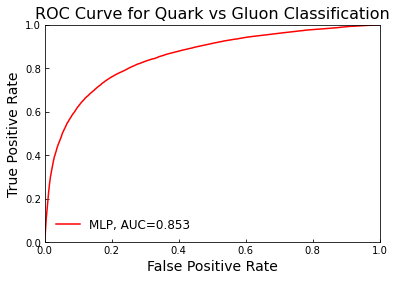

In [6]:
mlp_test_outputs = mlp_model(x_test_flat)
mlp_test_probs = torch.sigmoid(mlp_test_outputs).cpu().detach()
threshes = torch.linspace(0, 1, 1000)
mlp_tpr = (mlp_test_probs >= threshes[:, None])[:, y_test == 1].float().mean(1)
mlp_fpr = (mlp_test_probs >= threshes[:, None])[:, y_test == 0].float().mean(1)

plt.plot(mlp_fpr, mlp_tpr, label=f'MLP, AUC={-torch.trapz(mlp_tpr,mlp_fpr):.3f}', color='red')
plt.tick_params(axis='both', direction='in')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Quark vs Gluon Classification', fontsize=16)
plt.legend(frameon=False, fontsize=12)

We can see that we're doing better than randomly guessing here. We could probably improve further by doing some hyperparameter optimization, and certainly by training on more data.

We'll take a different tack though; let's try to use some of the structure in the data that we've discarded so far. In particular, we'll use Deep Sets, introduced in https://arxiv.org/abs/1703.06114 and brought to the particle physics literature in https://arxiv.org/abs/1810.05165; we'll use the Particle Flow Network (PFN) architecture described in this latter reference.

The idea here comes from the Deep Sets Theorem, which for our purposes says that any function $f$ on a set $S$ (which is necessarily permutation invariant, since sets are unordered) can be approximated as:

$$
f(S) \approx F(\sum_i \Phi(s_i)),
$$

where the $s_i$ are the elements of $S$, $\Phi$ is a function taking set elements to $\mathbb{R}^L$ with $L$ being called the latent space dimensionality, and $F$ is a function from $L$ to the image of $f$. Assuming that $\Phi$ and $F$ are universal function approximators, e.g. very wide MLPs, the approximation becomes exact as $L \to \infty$. The sum over set elements can be replaced with other permutation invariant aggregation functions, but we'll restrict our focus to sums for simplicity.

A PFN is then defined as follows: we'll interpret each jet as a set of particles, so $\Phi$ transforms particle phase space into the latent space, the sum aggregates information from all of the particles, and $F$ performs jet classification from this latent space.

We'll construct our own version of the Linear layer which acts at the particle level.

In [7]:
class ParticleLevelLinear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ParticleLevelLinear, self).__init__()
        self.weights = nn.Parameter((torch.rand(input_dim, output_dim) * 2 / input_dim**0.5) - 1/input_dim**0.5)
        self.bias = nn.Parameter((torch.rand(output_dim) * 2 / input_dim**0.5) - 1/input_dim**0.5)

    def forward(self, x):
        return torch.einsum('abc,cd->abd', x, self.weights) + self.bias

class PFN(nn.Module):
    def __init__(self, input_dim, L, phi_hidden_dim, f_hidden_dim):
        super(PFN, self).__init__()
        self.phi_fc1 = ParticleLevelLinear(input_dim, phi_hidden_dim)
        self.phi_fc2 = ParticleLevelLinear(phi_hidden_dim, phi_hidden_dim)
        self.phi_fc3 = ParticleLevelLinear(phi_hidden_dim, L)
        self.f_fc1 = nn.Linear(L, f_hidden_dim)
        self.f_fc2 = nn.Linear(f_hidden_dim, f_hidden_dim)
        self.f_fc3 = nn.Linear(f_hidden_dim, f_hidden_dim)
        self.f_fc4 = nn.Linear(f_hidden_dim, 1)
        print("PFN initialized with input_dim:", input_dim, "L:", L, "phi_hidden_dim:", phi_hidden_dim, "f_hidden_dim:", f_hidden_dim, "output_dim:", 1)
        print("Total number of parameters:", sum(p.numel() for p in self.parameters() if p.requires_grad))

    def forward(self, x):
        mask = x[:, :, 0] > 0
        x = F.relu(self.phi_fc1(x))
        x = F.relu(self.phi_fc2(x))
        x = self.phi_fc3(x)  # (N, P, L)
        x = (x * mask.unsqueeze(2)).sum(dim=1)  # Sum over particles, masking out zero padded ones
        x = F.relu(self.f_fc1(x))
        x = F.relu(self.f_fc2(x))
        x = F.relu(self.f_fc3(x))
        x = self.f_fc4(x)
        return x[:, 0]

This training cell takes ten minutes on my laptop. Feel free to run this if you're running this tutorial on a GPU or if you want to see the training dynamics yourself, otherwise feel free to load the pretrained model.

In [8]:
train_efn = False
pfn_model = PFN(3, 64, 64, 64).to(device)
optimizer = optim.Adam(pfn_model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
if train_efn:
    pfn_train_losses, pfn_val_losses = train_func(pfn_model, optimizer, loss_fn, trainloader, valloader, num_epochs=1000, early_stopping=10)
else:
    pfn_state_dict = torch.load('trained_pfn_model.pth')
    pfn_model.load_state_dict(pfn_state_dict)

PFN initialized with input_dim: 3 L: 64 phi_hidden_dim: 64 f_hidden_dim: 64 output_dim: 1
Total number of parameters: 21121


/var/folders/ww/3sjztwms3yxdfdh5qx5sy8pc0000gn/T/ipykernel_93217/641363330.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pfn_state_dict = torch.load('trained_pfn_model

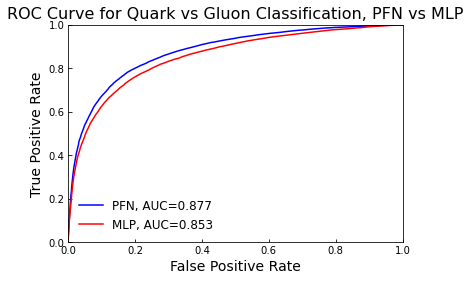

In [9]:
pfn_test_outputs = pfn_model(x_test)
pfn_test_probs = torch.sigmoid(pfn_test_outputs).cpu().detach()
threshes = torch.linspace(0, 1, 1000)
pfn_tpr = (pfn_test_probs >= threshes[:, None])[:, y_test == 1].float().mean(1)
pfn_fpr = (pfn_test_probs >= threshes[:, None])[:, y_test == 0].float().mean(1)
plt.plot(pfn_fpr, pfn_tpr, label=f'PFN, AUC={-torch.trapz(pfn_tpr,pfn_fpr):.3f}', color='blue')
plt.plot(mlp_fpr, mlp_tpr, label=f'MLP, AUC={-torch.trapz(mlp_tpr,mlp_fpr):.3f}', color='red')
plt.tick_params(axis='both', direction='in')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Quark vs Gluon Classification, PFN vs MLP', fontsize=16)
plt.legend(frameon=False, fontsize=12)

And we see that the PFN, which is tailored to the point cloud structure of the data, achieves better classification performance than the MLP. However, you could be forgiven for not being too impressed, since on my laptop the PFN takes ~40 times longer to train than the MLP, and it's not a priori obvious that an improvement in ROC-AUC of 0.02 is particularly important for real applications. As a counterpoint, however, note that today's state of the art transformer methods trained on much larger datasets attain an AUC of 0.92 (e.g. https://arxiv.org/abs/2202.03772), so an improvement from 0.86 to 0.88 brings one substantially closer to the frontier.

Now, let's move onto a more dramatic benefit of using a Deep Sets based methodology: it allows us to impose a symmetry called "IRC safety" on our classifier, which will make it more robust to mismodeling.

Recall from the introduction that a jet is created essentially as follows:

1) A high energy collision occurs between quark and/or gluon constituents of two hadrons
2) These constituents are knocked out of the hadron and shower off more quark and gluon radiation in a cascade
3) Eventually (or really, very, very quickly!) the energy is split between enough particles that the confining force binding the quarks and gluons to each other becomes dominant, and they recombine to form color neutral hadrons.

Depending on the energy of the collision, we have pretty strong theoretical control over the first two steps, but we have essentially no idea how to calculate the dynamics in the third step from first-principles; all we can do is apply phenomenological models. If we could design a classifier which was somehow insensitive to the physics of hadronization, we could be much more confident that it's capturing some aspect of reality as opposed to some flaw in our hadronization model. 

It turns out that a necessary (but not sufficient, see https://arxiv.org/abs/2311.07652. also, "necessary" is more like "necessaryish", see https://arxiv.org/abs/1307.1699) condition for this is called "infrared and collinear safety", or IRC safety. This condition says that the classifier's output shouldn't change if we add a new zero energy particle, and it also shouldn't change if we take one of the observed particles and split it into two collinear particles (with energy adding up to that of the original particle). 

One can get a vibes-level sense for why this is necessary to reduce sensitivity to hadronization by thinking about the end of the shower and the start of hadronization: if we don't want to be sensitive to hadronization, we also shouldn't be sensitive to exactly which low energy scale we take the transition from the shower to hadronization to occur at, so emitting arbitrarily low energy gluons, which could modify what happens during confinement, shouldn't change our answer. One can make a similar (vibes-level) argument that processes like a gluon splitting into two gluons, moving in the same direction but each with half the energy, shouldn't change our answer except through the confining dynamics. This isn't the right venue to go beyond the vibes level about the physics, but if you want something to Google, the relevant topics include the KLN theorem, and other references included in the two papers mentioned above.

Now that we've motivated why we might want our classifier to be IRC safe, let's see how Deep Sets lets us easily impose this symmetry. Consider the following slight modification of the PFN, which is called an Energy Flow Network (or EFN, introduced in the same reference as PFNs above):
$$
f(\text{jet}) = F\left(\sum_{i \in \text{jet}} z_i \Phi(\hat{p}_i)\right),
$$
where the sum is over particles in the jet, for each particle $z_i \equiv \frac{p_{T,i}}{\sum_j p_{T,j}}$ is the momentum fraction of the particle, and $\hat{p}_i$ is the unit vector of the particle's momentum in the $(y, \phi)$ plane.

One can see that this is automatically invariant to new zero energy particles, because their contribution to the sum is multiplied by zero, and it is also invariant to collinear splittings due to the sum's linearity in the momentum fraction.

We expect that an EFN classifier should achieve worse raw classification performance than a PFN classifier, because it's restricted to only use IRC safe information about the jets, but it should also be more robust to hadronization mismodeling. Let's implement it and check what the performance degradation looks like in practice!

Note: Recall that the dataset has shape $(N, P, 3)$, where the per-particle features are $(z, \hat{p}_1, \hat{p}_2)$, so you shouldn't have to do much preprocessing here!

In [10]:
class ParticleLevelLinear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ParticleLevelLinear, self).__init__()
        self.weights = nn.Parameter((torch.rand(input_dim, output_dim) * 2 / input_dim**0.5) - 1/input_dim**0.5)
        self.bias = nn.Parameter((torch.rand(output_dim) * 2 / input_dim**0.5) - 1/input_dim**0.5)

    def forward(self, x):
        return torch.einsum('abc,cd->abd', x, self.weights) + self.bias

class EFN(nn.Module):
    def __init__(self, input_dim, L, phi_hidden_dim, f_hidden_dim):
        super(EFN, self).__init__()
        self.phi_fc1 = ParticleLevelLinear(input_dim, phi_hidden_dim)
        self.phi_fc2 = ParticleLevelLinear(phi_hidden_dim, phi_hidden_dim)
        self.phi_fc3 = ParticleLevelLinear(phi_hidden_dim, L)
        self.f_fc1 = nn.Linear(L, f_hidden_dim)
        self.f_fc2 = nn.Linear(f_hidden_dim, f_hidden_dim)
        self.f_fc3 = nn.Linear(f_hidden_dim, f_hidden_dim)
        self.f_fc4 = nn.Linear(f_hidden_dim, 1)
        print("PFN initialized with input_dim:", input_dim, "L:", L, "phi_hidden_dim:", phi_hidden_dim, "f_hidden_dim:", f_hidden_dim, "output_dim:", 1)
        print("Total number of parameters:", sum(p.numel() for p in self.parameters() if p.requires_grad))

    def forward(self, x):
        zs = x[:, :, 0]
        xs = x[:, :, 1:]
        xs = F.relu(self.phi_fc1(xs))
        xs = F.relu(self.phi_fc2(xs))
        xs = self.phi_fc3(xs)  # (N, P, L)
        xs = (xs * zs.unsqueeze(2)).sum(dim=1)  # Sum over particles, masking out zero padded ones
        xs = F.relu(self.f_fc1(xs))
        xs = F.relu(self.f_fc2(xs))
        xs = F.relu(self.f_fc3(xs))
        xs = self.f_fc4(xs)
        return xs[:, 0]

This training cell takes ten minutes to train on my laptop. Feel free to run this if you're running this tutorial on a GPU or if you want to see the training dynamics yourself, otherwise feel free to load the pretrained model.

In [11]:
train_efn = False
efn_model = EFN(2, 64, 64, 64).to(device)
optimizer = optim.Adam(efn_model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
if train_efn:   
    efn_train_losses, efn_val_losses = train_func(efn_model, optimizer, loss_fn, trainloader, valloader, num_epochs=1000, early_stopping=10)
else:
    efn_state_dict = torch.load('trained_efn_model.pth')
    efn_model.load_state_dict(efn_state_dict)

PFN initialized with input_dim: 2 L: 64 phi_hidden_dim: 64 f_hidden_dim: 64 output_dim: 1
Total number of parameters: 21057


/var/folders/ww/3sjztwms3yxdfdh5qx5sy8pc0000gn/T/ipykernel_93217/97451766.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efn_state_dict = torch.load('trained_efn_model.

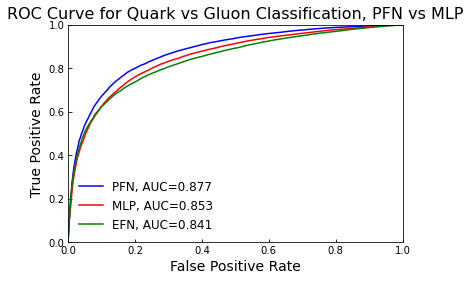

In [12]:
efn_test_outputs = efn_model(x_test)
efn_test_probs = torch.sigmoid(efn_test_outputs).cpu().detach()
threshes = torch.linspace(0, 1, 1000)
efn_tpr = (efn_test_probs >= threshes[:, None])[:, y_test == 1].float().mean(1)
efn_fpr = (efn_test_probs >= threshes[:, None])[:, y_test == 0].float().mean(1)
plt.plot(pfn_fpr, pfn_tpr, label=f'PFN, AUC={-torch.trapz(pfn_tpr,pfn_fpr):.3f}', color='blue')
plt.plot(mlp_fpr, mlp_tpr, label=f'MLP, AUC={-torch.trapz(mlp_tpr,mlp_fpr):.3f}', color='red')
plt.plot(efn_fpr, efn_tpr, label=f'EFN, AUC={-torch.trapz(efn_tpr,efn_fpr):.3f}', color='green')
plt.tick_params(axis='both', direction='in')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Quark vs Gluon Classification, PFN vs MLP', fontsize=16)
plt.legend(frameon=False, fontsize=12)